## OpenCVを用いた顔認識
OpenCVは画像解析や機械学習によく利用される、コンピュータービジョンライブラリの一つです。基本的な画像変換だけでなく、画像のフィルター処理、顔認識、物体認識、オブジェクトトラッキングなど、実務でよく利用される機能が一通りそろっている非常に使いやすいライブラリになっています。実務で画像認識系の仕事をする際は必ず利用するライブラリになっています。

こちらの記事ではOpenCVに標準で備わっている顔の検出を行ってみます。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/article/library/cv2/face/face_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/article/library/cv2/face/face_nb.ipynb)

### 環境
筆者のOSはmacOSです。LinuxやUnixのコマンドとはオプションが異なります。

### 筆者の環境

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G95


In [2]:
!python -V

Python 3.5.5 :: Anaconda, Inc.


In [3]:
import cv2

print('opencv version :', cv2.__version__)

opencv version : 3.4.1


画像表示用にmatplotlibもimportします。画像はwebでの見栄えを考慮して、svgで保存する事とします。

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

上の階層に lena.jpg というファイルがあるとします。

In [5]:
%%bash

ls -a ../ | grep jpg

binary_out.jpg
bitwise_out.jpg
gray_out.jpg
lena.jpg
lena_out.jpg
rotation.jpg
rotation_scale_1_angle_-30.jpg
rotation_scale_1_angle_30.jpg
rotation_scale_2_angle_-30.jpg
rotation_scale_2_angle_30.jpg


In [6]:
filename = '../lena.jpg'

## 画像の読み込み

画像を読み込み、表示してみます。jupyter notebookの中で表示させるため、matplotlibを利用しています。

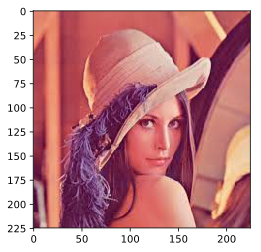

In [7]:
img = cv2.imread(filename=filename)

# OpenCVではGBRの準備で画像が読み込まれるが、JupyterNotebookではRGBで表示させる
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_img)
plt.show()

In [8]:
# 後のためにグレースケールの画像を作っておきます
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### 画像情報の取得

画像の高さ、幅、カラーの場合の色の数（通常RGBの3）を確認します。

In [9]:
def get_image_info(img):
  if len(img.shape) == 3:
    img_height, img_width, img_channels = img.shape[:3]
    print('img_channels :', img_channels)
  else:
    img_height, img_width = img.shape[:2]
    
  print('img_height :', img_height)
  print('img_width :', img_width)
  
get_image_info(img=img)

img_channels : 3
img_height : 225
img_width : 225


## 顔認識

OpenCVで人の顔を検出するには"haarcascade_frontalface_alt.xml"という顔認識用のモデルファイルを読み込みます。OpenCVには顔以外にも鼻や口などを認識するためのモデルもあります。

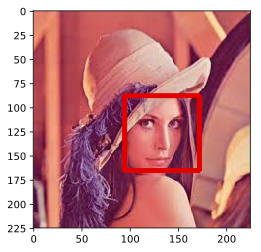

In [10]:
cascade_file = "haarcascade_frontalface_alt.xml"
cascade = cv2.CascadeClassifier(cascade_file)

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_list = cascade.detectMultiScale(gray_img, minSize=(50, 50))

# 検出した顔に印を付ける
for (x, y, w, h) in face_list:
  color = (0, 0, 225)
  pen_w = 3
  cv2.rectangle(img, (x, y), (x + w, y + h), color, thickness = pen_w)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 顔の特徴抽出（dlib）

dlibという顔の特徴量抽出を行うライブラリを利用して、表情の特徴を捉えることも出来ます。dlibのshape_predictorによって、68点の顔のモデルを読み込みます。これはOpenCVはありません。

以下のコードは、[「Python実践データ分析100本ノック」](https://www.amazon.co.jp/dp/B07ZSGSN9S/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1)の第9章 潜在顧客を把握するための画像処理10本ノックを参考にしています。この本はデータ分析に必要なスキルを広い範囲で解説してくれているのでとても重宝しています。

In [11]:
import dlib
import math

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

In [12]:
dets = detector(img, 1)

for k, d in enumerate(dets):
  shape = predictor(img, d)

  # 顔領域の表示
  color_f = (0, 0, 225)
  color_l_out = (255, 0, 0)
  color_l_in = (0, 255, 0)
  line_w = 3
  circle_r = 3
  fontType = cv2.FONT_HERSHEY_SIMPLEX
  fontSize = 1
  cv2.rectangle(img, (d.left(), d.top()), (d.right(), d.bottom()), color_f, line_w)
  cv2.putText(img, str(k), (d.left(), d.top()), fontType, fontSize, color_f, line_w)

  num_of_points_out = 17
  num_of_points_in = shape.num_parts - num_of_points_out
  gx_out = 0
  gy_out = 0
  gx_in = 0
  gy_in = 0
  
  for shape_point_count in range(shape.num_parts):
    shape_point = shape.part(shape_point_count)
    
    #器官ごとに描画
    if shape_point_count<num_of_points_out:
      cv2.circle(img,(shape_point.x, shape_point.y),circle_r,color_l_out, line_w)
      gx_out = gx_out + shape_point.x/num_of_points_out
      gy_out = gy_out + shape_point.y/num_of_points_out
    else:
      cv2.circle(img,(shape_point.x, shape_point.y),circle_r,color_l_in, line_w)
      gx_in = gx_in + shape_point.x/num_of_points_in
      gy_in = gy_in + shape_point.y/num_of_points_in

  # 重心位置を描画
  cv2.circle(img,(int(gx_out), int(gy_out)),circle_r,(0,0,255), line_w)
  cv2.circle(img,(int(gx_in), int(gy_in)),circle_r,(0,0,0), line_w)

  # 顔の方位を計算
  theta = math.asin(2*(gx_in-gx_out)/(d.right()-d.left()))
  radian = theta*180/math.pi
  print("顔方位:{} (角度:{}度)".format(theta,radian))

  # 顔方位を表示
  if radian<0:
    textPrefix = "   left "
  else:
    textPrefix = "   right "
  textShow = textPrefix + str(round(abs(radian),1)) + " deg."
  cv2.putText(img, textShow, (d.left(), d.top()), fontType, fontSize, color_f, line_w)

顔方位:0.30929631910812816 (角度:17.72137370382726度)


lenaさんが右の方向を向いていることが分かりました。また、その角度も計算されています。

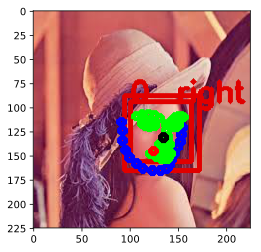

In [13]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 結論
OpenCVは非常に使い勝手がよい画像解析ライブラリです。最近はディープラーニングによる認識が流行っていますが、コストとの対比を考えると、OpenCVで十分な場合も多々あります。私は画像解析でディープラーニングを用いて精度を高められませんかという依頼をもらったときは、果たしてディープラーニングを利用する必要があるのかどうか、もっと低コストに顧客が満足する方法があるのではないかと考えながら提案をしています。

もしOpenCVの様々なモジュールを使って十分な精度が得られれば、比較的高コストのディープラーニングは不要な場合もよく見られます。